# Polygon Feature: Country Cut-Out of Switzerland

The following notebook demonstrates the full workflow to access, process and visualize ICON-CH1-EPS model data within the border of Switzerland using 2-meter temperature data. 

<p align="center">
    <img src="./images/t_2m_country_cut-out.png" style="width:50%;">
</p>

The data is retrieved using [Polytope](https://polytope.readthedocs.io/en/latest/), a feature extraction software developed by ECMWF. It applies concepts of computational geometry to extract n-dimensional polygons (also known as polytopes) from datacubes, such as a country cut-out. To access MeteoSwiss' operational ICON-CH1-EPS and ICON-CH2-EPS model data, [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) provides a wrapper around the polytope client that simplifies the request API. Follow the instructions to learn more about model data access via Polytope.

## Installation
Install all necessary requirements to run the notebook by visiting the installation instructions in [README.md](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1).

## Configuring Access to Polytope
To use ICON CSCS polytope, you need a polytope offline token provided by MeteoSwiss. If you do not already have a token, you can request one [here](https://meteoswiss.atlassian.net/wiki/spaces/IW2/pages/327780397/Polytope#Offline-token-authentication).

In [1]:
import os

#ICON-CSCS polytope credentials
os.environ["POLYTOPE_USERNAME"] = "xxx"
os.environ["POLYTOPE_PASSWORD"] = "xxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"

## Selecting date and time of the forecast

The real-time FDB typically **includes only the most recent day of forecasts**. Therefore, it is necessary to specify the current date and select a corresponding forecast time in the past.

In [2]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time

('20250915', '0000')

### Extract the country polygon of Switzerland
In our example we are looking for the shape of Switzerland with a resolution of 50'000'000 meters. With [earthkit.geo](https://earthkit-geo.readthedocs.io/en/latest/) it is possible to extract one or more country shapes using the function [country_polygons()](https://earthkit-geo.readthedocs.io/en/latest/_api/geo/cartography/index.html#geo.cartography.country_polygons).

In [3]:
import earthkit.geo.cartography

shapes = earthkit.geo.cartography.country_polygons("Switzerland", resolution=50e6)

### Rotate the polygon points

To use the polytope feature, it is necessary to rotate the given data using a South Pole rotation with a reference of longitude 10° and latitude of -43°. 
> **IMPORTANT**: The variable `shapes` contains tuples of first latitude and then longitude. However, the function `transform_point()` expects first longitude and then latitude.

In [4]:
import cartopy.crs as ccrs

# South pole rotation of lon=10, latitude=-43
rotated_crs = ccrs.RotatedPole(
    pole_longitude=190, pole_latitude=43
)

# Convert a point from geographic to rotated coordinates
geo_crs = ccrs.PlateCarree()
rotated_points = [
    rotated_crs.transform_point(lon, lat, geo_crs)
    for lat, lon in shapes[0]
]

## Define the request

Once the data is rotated, we need to define a mars request using [meteodata-lab](https://polytope.readthedocs.io/en/latest/). The `feature` attribute allows you to extract **only the relevant data at the given points**. Thus, the amount of data that is retrieved from storage is significantly reduced. For the "polygon" `feature` the following dictionary is needed.
> **IMPORTANT**: Don't forget to specify that the data points are tuples that first contain longitude and then latitude.

In [5]:
feature={
    "type" : "polygon",
    "shape" : rotated_points,
    "axes" : ["longitude", "latitude"] #first longitude, then latitude
}

Finally, we can define the request.

In [6]:
from meteodatalab import mars

request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    type="pf",
    number=1,
    step=0,
    feature=feature
)

## Data retrieval
Now we use [earthkit.data](https://earthkit-data.readthedocs.io/en/latest/) to load the data and convert it into an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [7]:
import earthkit.data as ekd
ds = ekd.from_source(
    "polytope",
    "mchgj",
    request.to_polytope(),
    stream=False
).to_xarray()

2025-09-15 14:32:12 - INFO - Sending request...
{'request': 'class: od\n'
            "date: '20250915'\n"
            "expver: '0001'\n"
            'feature:\n'
            '  axes:\n'
            '  - longitude\n'
            '  - latitude\n'
            '  shape:\n'
            '  - - -0.3214282328163866\n'
            '    - 0.5251951878603222\n'
            '  - - -0.3009932170319198\n'
            '    - 0.5119888291642757\n'
            '  - - -0.25291862386558006\n'
            '    - 0.467644919693353\n'
            '  - - -0.26464927076478134\n'
            '    - 0.3924571597916829\n'
            '  - - -0.320582802510431\n'
            '    - 0.2717186295824706\n'
            '  - - -0.3505828886224941\n'
            '    - 0.17381018665949025\n'
            '  - - -0.35433501257449107\n'
            '    - 0.09868687377616639\n'
            '  - - -0.3489813603418016\n'
            '    - 0.06339691180464574\n'
            '  - - -0.33899989602223873\n'
            '    -

## Reverse rotation
The data in the dataset contains rotated longitudes and latitudes. To plot it, we need to reverse the rotation.

In [8]:
unrotated_points = [
    geo_crs.transform_point(lon, lat, rotated_crs)
    for lon, lat in zip(ds.longitude,ds.latitude)
]

geo_lons, geo_lats = zip(*unrotated_points)

ds_geo = ds.assign_coords(
    longitude=("points", list(geo_lons)),
    latitude=("points", list(geo_lats))
)

## Plotting

We use the library [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) to plot the data. Moreover, we can specify a styling with [earthkit.plots.styles](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/04-styles.html#4.-Styles) to show a color spectrum from red to blue and convert the unit to degrees Celsius for better readability.

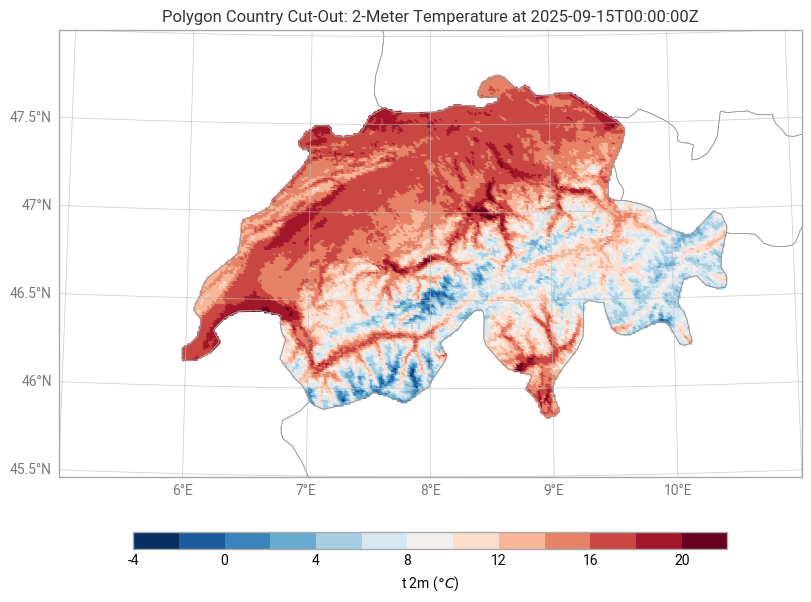

In [9]:
from earthkit.plots import Map
from earthkit.plots.styles import Style
from earthkit.plots.geo import bounds, domains

xmin, xmax = 5, 11   # Longitude bounds
ymin, ymax = 45.5, 48   # Latitude bounds

bbox = bounds.BoundingBox(xmin, xmax, ymin, ymax, ccrs.Geodetic())
domain = domains.Domain.from_bbox(
    bbox=bbox,
    name="CH2"
)

style = Style(colors="RdBu_r", units="celsius")
chart = Map(domain=domain)
chart.point_cloud(ds_geo["t_2m"], x="longitude", y="latitude", style=style)

chart.coastlines()
chart.borders()
chart.gridlines()


chart.title("Polygon Country Cut-Out: 2-Meter Temperature at {datetimes}")

chart.legend()

chart.show()